# Notebook comparing the performance of BiLSTM and Transformer Encoder for NER in Malayalam.

- Uses the malayalam subset of [ai4bharat/naamapadam](https://huggingface.co/datasets/ai4bharat/naamapadam/viewer/ml/train)

- This notebook was used to define and train a 3 layer BiLSTM as well as a 2 layer transformer encoder.

- Uses BPE tokenizer from https://bpemb.h-its.org/

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
!pip install wandb datasets torchmetrics bpemb pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from torchmetrics import F1Score

In [4]:
from datasets import load_dataset

In [5]:
indic_ner_data = load_dataset("ai4bharat/naamapadam", 'ml')

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset naamapadam downloaded and prepared to /root/.cache/huggingface/datasets/ai4bharat___naamapadam/ml/1.0.0/c1b045180d60b208d2468bdad897d04461f08c7137c04a85220697b1bef7df9a. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
indic_ner_data

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 716652
    })
    test: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 974
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 3618
    })
})

In [10]:
def __extract_non_zero(x, cutoff):
  ## Was used to extract out sentences with only 0 tags.
  count = 0
  for i in x:
    if i != 0:
      count += 1
  return count > cutoff

In [11]:
def __extract_non_zero_percentage(x, cutoff):
  ## was used for the same purpose by above but using a percentage crietria to accout for thr length info
  ## NOTE: This was not used in the final model.
  count = 0
  for i in x:
    if i != 0:
      count += 1
  return (count / len(x)) > cutoff

### Getting Train, Valid, & Test Data

In [12]:
ds_train = list(filter(lambda x: __extract_non_zero(x['ner_tags'], 0), indic_ner_data['train']))
ds_val = indic_ner_data['validation']
ds_test = indic_ner_data['test']

In [71]:
ids_to_tags = {
    0 : 'O',
    1 : 'B-PER',
    2 : 'I-PER',
    3 : 'B-ORG',
    4 : 'I-ORG',
    5 : 'B-LOC',
    6 : 'I-LOC'
}

Visualizing the distribution of tags in the dataset.

In [6]:
import matplotlib.pyplot as plt

In [16]:
def visualize_tag_distribution(split):
  res = []
  for pair in split:
    res.extend(pair['ner_tags'])
  plt.hist(res)

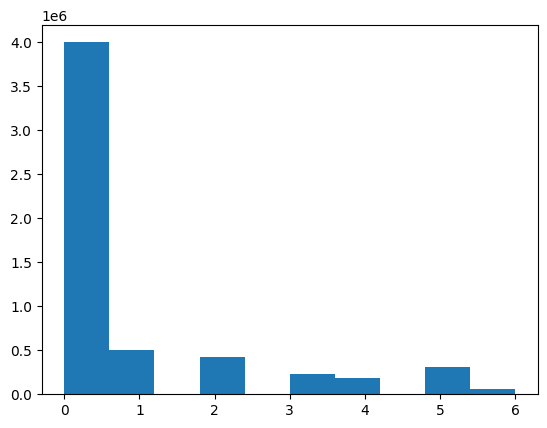

In [17]:
visualize_tag_distribution(ds_train)

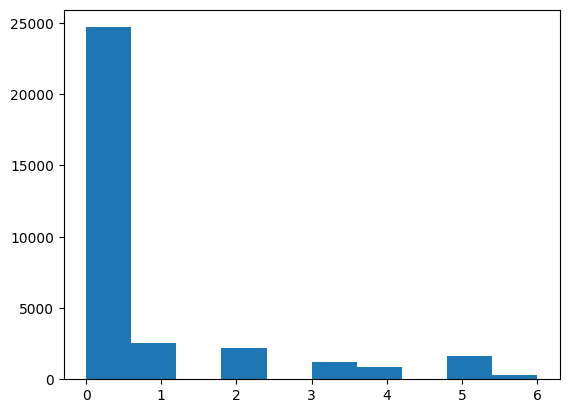

In [19]:
visualize_tag_distribution(ds_val)

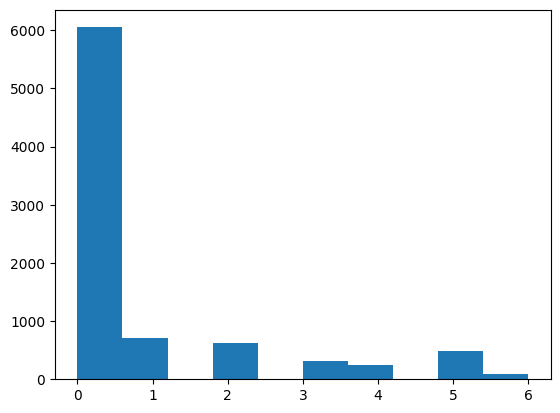

In [20]:
visualize_tag_distribution(ds_test)

We've got similar distribution accross our train, validation and test splits. We can also see that 0 (Other) tag dominates accross the three splits. Whereas, 6 is in the minority accros the three splits.

## Preprocessing

In [21]:
import string
import unicodedata

def remove_unicode_control_chars(text):
    """Remove all Unicode control characters from a string."""
    cleaned_text = ''.join(c for c in text if unicodedata.category(c)[0] != 'C')
    return cleaned_text

### BPE Tokenizer

In [7]:
from bpemb import BPEmb

In [8]:
bpemb_ml = BPEmb(lang='ml', add_pad_emb=True)

downloading https://nlp.h-its.org/bpemb/ml/ml.wiki.bpe.vs10000.model


100%|██████████| 483966/483966 [00:00<00:00, 603685.20B/s]


downloading https://nlp.h-its.org/bpemb/ml/ml.wiki.bpe.vs10000.d100.w2v.bin.tar.gz


100%|██████████| 3801593/3801593 [00:01<00:00, 2686864.59B/s]


In [ ]:
bpemb_ml.encode_ids_with_bos_eos('ആരാണ് നായ്ക്കളെ പുറത്താക്കിയത് <pad><pad>')

[1,
 1743,
 58,
 1104,
 9813,
 4054,
 3049,
 4344,
 9814,
 0,
 9886,
 573,
 9992,
 0,
 9886,
 573,
 9992,
 2]

In [ ]:
bpemb_ml.encode_ids_with_bos_eos('ആരാണ് നായ്ക്കളെ പുറത്താക്കിയത്')

[1, 1743, 58, 1104, 9813, 4054, 3049, 4344, 2]

In [ ]:
bpemb_ml

BPEmb(lang=ml, vs=10000, dim=100)

### Torch Dataset

In [23]:
len(ds_train), len(ds_val), len(ds_test)

(564126, 3618, 974)

In [24]:
from torch.utils.data import Dataset, DataLoader

In [25]:
class MalayalamNERDataset(Dataset):
    def __init__(self, split, tokenizer: BPEmb, crfs: bool=False):
        self.split = split
        self.tokenizer = tokenizer
        self.max_token_len = self._get_max_token_len()
        self.crfs = crfs

    def __len__(self):
        return len(self.split)

    def _get_max_token_len(self):
        max_len = 100
        # for i in range(len(self.split)):
        #     max_len = max(max_len, len(self.tokenizer.encode(self.split[i]['tokens'])))
        # print(max_len)
        return max_len

    def _align_labels(self, tokens, ner_tags):
        inter_tokens = self.tokenizer.encode(tokens)
        current_tag = None
        ner = -1
        labels = []
        for token in inter_tokens:
            if token[0] == '▁':
                ner += 1
                current_tag = ner_tags[ner]
                labels.append(current_tag)
            else:
                labels.append(current_tag)
        return [0] + labels + [0]

    def _pad_tokens_and_tags_get_mask(self, tokens: str, ner_tags):
        tokens: list[str] = self.tokenizer.encode_ids_with_bos_eos(tokens)
        padding_len: int = self.max_token_len - len(tokens)
        ner_tags = torch.tensor(ner_tags, dtype=torch.int64)
        if padding_len < 0:
            tokens = tokens[:self.max_token_len - 1]
            tokens = tokens + [self.tokenizer.EOS]
            tokens = torch.tensor(tokens, dtype=torch.int64)
            ner_tags = ner_tags[:self.max_token_len]
        else:
            padding_vectors = torch.zeros(padding_len) - 1
            tokens = torch.tensor(tokens, dtype=torch.int64)
            tokens = torch.cat([tokens, padding_vectors], axis=0)
            ner_tags = torch.cat([ner_tags, torch.zeros(padding_len)], axis=0).long()
        if not self.crfs:
          ner_tags = F.one_hot(ner_tags, num_classes=7)
        mask = tokens > 0
        tokens[~mask] = 0
        return tokens, mask, ner_tags

    def __getitem__(self, idx):
        tokens = " ".join(self.split[idx]['tokens'])
        tokens = remove_unicode_control_chars(tokens)
        tokens = tokens.translate(str.maketrans('', '', string.punctuation))
        tokens = " ".join(tokens.split())
        ner_tags = self.split[idx]['ner_tags']
        ner_tags = self._align_labels(tokens, ner_tags)
        tokens, mask, ner_tags = self._pad_tokens_and_tags_get_mask(tokens, ner_tags)
        ner_tags = ner_tags.float() if not self.crfs else ner_tags.long()
        mask = mask.long() if not self.crfs else mask.bool()
        return tokens.long(), ner_tags, mask

In [ ]:
tokens, ner_tags, mask = MalayalamNERDataset(indic_ner_data['train'], bpemb_ml, crfs=True)[300]
ner_tags

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0])

In [26]:
train_dataset = MalayalamNERDataset(split=indic_ner_data['train'], tokenizer=bpemb_ml, crfs=False)
val_dataset = MalayalamNERDataset(split=indic_ner_data['validation'], tokenizer=bpemb_ml, crfs=False)
test_dataset = MalayalamNERDataset(split=indic_ner_data['test'], tokenizer=bpemb_ml, crfs=False)

In [27]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=256, shuffle=True, num_workers=0)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=256, num_workers=0)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=32, num_workers=0)

In [ ]:
tokens, ner_tags, mask = next(iter(train_dataloader))

In [ ]:
ner_tags[0]

tensor([[1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1.,

### Modelling BiLSTM

In [28]:
class BiLSTM_MAL(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, nonlinearity, bias, dropout, bidirectional=False, batch_first=True, num_classes=7):
        super(BiLSTM_MAL, self).__init__()
        self.emb_layer = nn.Embedding.from_pretrained(torch.tensor(bpemb_ml.vectors))
        self.emb_layer.weight.requires_grad = False
        self.rnn = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            # nonlinearity=nonlinearity,
            bias=bias,
            dropout=dropout,
            bidirectional=bidirectional,
            batch_first=batch_first
        )
        self.bc = nn.LayerNorm(hidden_size * 2)
        self.first_bc = nn.LayerNorm(100)
        self.linear = nn.Sequential(
            nn.Linear(2 * hidden_size, hidden_size),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_size, num_classes)
        )
        self.init_weights()

    def init_weights(self):
        for name, param in self.named_parameters():
          if "weight_ih" in name:
              nn.init.xavier_uniform_(param)
          elif "weight_hh" in name:
              nn.init.orthogonal_(param)
          elif "bias" in name:
              nn.init.constant_(param, 0)

    def forward(self, tokens, mask):
        embeddings = self.emb_layer(tokens)
        embeddings = self.first_bc(embeddings)
        # print(embeddings)
        rnn_output, _ = self.rnn(embeddings)
        # rnn_output = rnn_output @ mask
        rnn_output = self.bc(rnn_output)
        linear_output = self.linear(rnn_output)
        return linear_output


In [29]:
bi_lstm = BiLSTM_MAL(
    input_size=100,
    hidden_size=200,
    num_layers=3,
    dropout=0.3,
    nonlinearity='relu',
    bias=True,
    bidirectional=True
)

Sanity Checking BiLSTM

In [30]:
t_iter = iter(train_dataloader)
data = next(t_iter)

In [31]:
res = bi_lstm(data[0], data[2])

In [32]:
res

tensor([[[ 3.0982e-02,  2.9697e-01, -5.4519e-02,  ...,  1.6691e-01,
           3.3146e-01, -6.3497e-02],
         [ 1.0871e-01,  1.9668e-01, -1.5136e-02,  ..., -1.0958e-02,
           2.1271e-01, -4.6125e-02],
         [ 1.3939e-02,  2.8673e-01,  7.1974e-03,  ...,  3.2329e-02,
           1.9819e-01, -1.0108e-01],
         ...,
         [-3.2262e-02,  3.9115e-01, -3.0547e-01,  ...,  1.7685e-01,
           1.6928e-01, -9.4398e-02],
         [ 3.9201e-02,  1.5584e-01, -2.9331e-01,  ...,  9.7247e-02,
           1.9430e-01, -8.5344e-02],
         [ 3.5654e-05,  2.0788e-01, -3.0766e-01,  ...,  2.0523e-01,
           1.3163e-01, -1.9457e-01]],

        [[ 2.1873e-01,  4.0731e-02, -8.7935e-03,  ...,  3.2213e-01,
           1.7551e-01, -1.8190e-02],
         [ 2.3034e-01, -1.6202e-02, -1.7750e-01,  ...,  3.8735e-01,
           1.5101e-01,  2.3947e-02],
         [ 1.6353e-01,  1.5991e-01, -2.8321e-01,  ...,  4.6854e-01,
           2.0916e-01,  4.5766e-02],
         ...,
         [ 9.7975e-02,  1

In [33]:
res.shape

torch.Size([256, 100, 7])

BiLSTM Pytorch Lightning

In [34]:
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger

In [ ]:
wand = WandbLogger(name='NER-TENER-FUll-DATA_CLEANED', log_model=True)

In [ ]:
wandb.finish()

In [ ]:
import wandb

In [35]:
from torchmetrics import ConfusionMatrix

In [36]:
f1 = F1Score(task="multiclass", num_classes=7).to('cuda' if torch.cuda.is_available() else 'cpu')
confmat = ConfusionMatrix(task="multiclass", num_classes=7)

In [37]:
class BiLSTMLightning(pl.LightningModule):
    def __init__(self, model: nn.Module):
        super().__init__()
        self.model = model

    def training_step(self, batch, batch_idx):
        tokens, ner_tags, mask = batch
        output = self.model(tokens, mask)
        output_reshaped = output.view(-1, 7)
        ner_tags_reshaped = ner_tags.view(-1, 7)
        loss = F.cross_entropy(input=output_reshaped, target=ner_tags_reshaped, weight=torch.Tensor([0.2, 1.0, 1.0, 2.0, 2.0, 2.0, 7.0]).to('cuda' if torch.cuda.is_available() else 'cpu'))
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        tokens, ner_tags, mask = batch
        output = self.model(tokens, mask)
        output_reshaped = output.view(-1, 7)
        ner_tags_reshaped = ner_tags.view(-1, 7)
        loss = F.cross_entropy(input=output_reshaped, target=ner_tags_reshaped, weight=torch.Tensor([0.5, 1.0, 1.0, 2.0, 2.0, 2.0, 7.0]).to('cuda' if torch.cuda.is_available() else 'cpu'))
        output_tags = torch.argmax(output_reshaped, dim=1)
        original_tags = torch.argmax(ner_tags_reshaped, dim=1)
        f1_score = f1(output_tags, original_tags)
        self.log('f1_score', f1_score)
        self.log('val_loss', loss)
        return loss

    def test_step(self, batch, batch_idx):
        tokens, ner_tags, mask = batch
        output = self.model(tokens, mask)
        output_reshaped = output.view(-1, 7)
        ner_tags_reshaped = ner_tags.view(-1, 7)
        loss = F.cross_entropy(input=output_reshaped, target=ner_tags_reshaped)
        output_tags = torch.argmax(output_reshaped, dim=1)
        original_tags = torch.argmax(ner_tags_reshaped, dim=1)
        f1_score = f1(output_tags, original_tags)
        self.log('f1_score', f1_score)
        self.log('test_loss', loss)
        conf_matrix = wandb.plot.confusion_matrix(probs=None, y_true=original_tags.cpu().numpy(), preds=output_tags.cpu().numpy(), class_names=list(range(7)))
        self.logger.experiment.log({"confusion_matrix": conf_matrix})
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(params=self.model.parameters(), lr=0.01)

In [38]:
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

In [39]:
early_stopping_callbacks = EarlyStopping(monitor="train_loss", mode="min")
model_checkpoint_callbacks = ModelCheckpoint(filename='best_model', monitor='val_loss', mode='min')

In [ ]:
trainer = pl.Trainer(logger=wand, min_epochs=5, max_epochs=20, accelerator='gpu', gradient_clip_val=1.0,callbacks=[early_stopping_callbacks, model_checkpoint_callbacks])

In [40]:
bi_lstm_pl = BiLSTMLightning(bi_lstm)

In [ ]:
trainer.fit(model=bi_lstm_pl, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

In [ ]:
trainer.test(dataloaders=test_dataloader, model=bi_lstm_pl)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         f1_score          │    0.9687063097953796     │
│         test_loss         │    0.09296657890081406    │
└───────────────────────────┴───────────────────────────┘

[{'f1_score': 0.9687063097953796, 'test_loss': 0.09296657890081406}]

### Modelling TENER (Transformer Encoder for NER, Link: https://arxiv.org/pdf/1911.04474v3.pdf)

Some differences from the paper:
- I've decided to use the same positional embeddings as vanilla transformers
- I have dropped the CRF layer, as it was leading to some instability during training, got to work out why that is.
- Since there is severe imbalance in the data, I've weighed the loss of each class in the cross entropy loss.
- I've taken d_model = 512 and n_head = 16

In [43]:
import math

In [44]:
class MultiHeadAttn(nn.Module):
    def __init__(self, d_model, n_head, dropout=0.1, scale=False):
        super().__init__()
        assert d_model%n_head==0

        self.n_head = n_head
        self.qkv_linear = nn.Linear(d_model, 3*d_model, bias=False)
        self.fc = nn.Linear(d_model, d_model)
        self.dropout_layer = nn.Dropout(dropout)

        if scale:
            self.scale = math.sqrt(d_model//n_head)
        else:
            self.scale = 1

    def forward(self, x, mask):
        batch_size, max_len, d_model = x.size()
        x = self.qkv_linear(x)
        q, k, v = torch.chunk(x, 3, dim=-1)
        q = q.view(batch_size, max_len, self.n_head, -1).transpose(1, 2)
        k = k.view(batch_size, max_len, self.n_head, -1).permute(0, 2, 3, 1)
        v = v.view(batch_size, max_len, self.n_head, -1).transpose(1, 2)

        attn = torch.matmul(q, k)  # batch_size x n_head x max_len x max_len
        attn = attn/self.scale
        attn.masked_fill_(mask=mask[:, None, None].eq(0), value=float('-inf'))

        attn = F.softmax(attn, dim=-1)  # batch_size x n_head x max_len x max_len
        attn = self.dropout_layer(attn)
        v = torch.matmul(attn, v)  # batch_size x n_head x max_len x d_model//n_head
        v = v.transpose(1, 2).reshape(batch_size, max_len, -1)
        v = self.fc(v)

        return v

In [45]:
class TransformerLayer(nn.Module):
    def __init__(self, d_model, self_attn, feedforward_dim, after_norm, dropout):
        super().__init__()

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

        self.self_attn = self_attn

        self.after_norm = after_norm

        self.ffn = nn.Sequential(nn.Linear(d_model, feedforward_dim),
                                 nn.ReLU(),
                                 nn.Dropout(dropout),
                                 nn.Linear(feedforward_dim, d_model),
                                 nn.Dropout(dropout))

    def forward(self, x, mask):
        residual = x
        if not self.after_norm:
            x = self.norm1(x)

        x = self.self_attn(x, mask)
        x = x + residual
        if self.after_norm:
            x = self.norm1(x)
        residual = x
        if not self.after_norm:
            x = self.norm2(x)
        x = self.ffn(x)
        x = residual + x
        if self.after_norm:
            x = self.norm2(x)
        return x

In [46]:
def make_positions(tensor, padding_idx):
    """Replace non-padding symbols with their position numbers.
    Position numbers begin at padding_idx+1. Padding symbols are ignored.
    """
    # The series of casts and type-conversions here are carefully
    # balanced to both work with ONNX export and XLA. In particular XLA
    # prefers ints, cumsum defaults to output longs, and ONNX doesn't know
    # how to handle the dtype kwarg in cumsum.
    mask = tensor.ne(padding_idx).int()
    return (
        torch.cumsum(mask, dim=1).type_as(mask) * mask
    ).long() + padding_idx

    
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 100):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(0).unsqueeze(-1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(1, max_len,d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Arguments:
            x: Tensor, shape ``[batch_size, seq_len, embedding_dim]``
        """
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

In [47]:
from copy import deepcopy

class TransformerEncoder(nn.Module):
    def __init__(self, num_layers, d_model, n_head, feedforward_dim, dropout, after_norm=True, attn_type='transformer',
                 scale=False, dropout_attn=None, pos_embed=None):
        super().__init__()
        if dropout_attn is None:
            dropout_attn = dropout
        self.d_model = d_model
        self.pos_embed = PositionalEncoding(d_model, max_len=100) if pos_embed else None
        self_attn = MultiHeadAttn(d_model, n_head, dropout_attn, scale=scale)
        self.layers = nn.ModuleList([TransformerLayer(d_model, deepcopy(self_attn), feedforward_dim, after_norm, dropout)
                       for _ in range(num_layers)])

    def forward(self, x, mask):
        if self.pos_embed is not None:
            res = self.pos_embed(x)
            x = x + res
        for layer in self.layers:
            x = layer(x, mask)
        return x

In [66]:
class TENER(nn.Module):
  def __init__(self, d_model):
    super(TENER, self).__init__()
    self.in_fc = nn.Linear(100, d_model)
    self.transformer = TransformerEncoder(num_layers=2, d_model=512, n_head=16, feedforward_dim=512*2, dropout=0.3, pos_embed='mine', scale=True)
    self.fc_dropout = nn.Dropout(0.3)
    self.out_fc = nn.Linear(d_model, 7)
    self.emb_layer = nn.Embedding.from_pretrained(torch.tensor(bpemb_ml.vectors))
    self.emb_layer.weight.requires_grad = False
  
  def forward(self, tokens, mask):
    tokens = self.emb_layer(tokens)
    tokens = self.in_fc(tokens)
    tokens = self.transformer(tokens, mask)
    tokens = self.fc_dropout(tokens)
    tokens = self.out_fc(tokens)
    return tokens

In [50]:
tener_ml = TENER(512)

In [51]:
t_iter = iter(train_dataloader)
data = next(t_iter)

In [52]:
tener_ml(data[0], data[2]).shape

torch.Size([256, 100, 7])

In [67]:
class TENER_MAL(pl.LightningModule):
    def __init__(self, model: nn.Module):
        super().__init__()
        self.model = model

    def training_step(self, batch, batch_idx):
        tokens, ner_tags, mask = batch
        output = self.model(tokens, mask)
        output_reshaped = output.view(-1, 7)
        ner_tags_reshaped = ner_tags.view(-1, 7)
        loss = F.cross_entropy(input=output_reshaped, target=ner_tags_reshaped, weight=torch.Tensor([0.5, 1.0, 1.0, 2.0, 2.0, 2.0, 3.0]).to('cuda' if torch.cuda.is_available() else 'cpu'))
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        tokens, ner_tags, mask = batch
        output = self.model(tokens, mask)
        output_reshaped = output.view(-1, 7)
        ner_tags_reshaped = ner_tags.view(-1, 7)
        loss = F.cross_entropy(input=output_reshaped, target=ner_tags_reshaped, weight=torch.Tensor([0.5, 1.0, 1.0, 2.0, 2.0, 2.0, 3.0]).to('cuda' if torch.cuda.is_available() else 'cpu'))
        output_tags = torch.argmax(output_reshaped, dim=1)
        original_tags = torch.argmax(ner_tags_reshaped, dim=1)
        f1_score = f1(output_tags, original_tags)
        self.log('f1_score', f1_score)
        self.log('val_loss', loss)
        return loss

    def test_step(self, batch, batch_idx):
        tokens, ner_tags, mask = batch
        output = self.model(tokens, mask)
        output_reshaped = output.view(-1, 7)
        ner_tags_reshaped = ner_tags.view(-1, 7)
        loss = F.cross_entropy(input=output_reshaped, target=ner_tags_reshaped)
        output_tags = torch.argmax(output_reshaped, dim=1)
        original_tags = torch.argmax(ner_tags_reshaped, dim=1)
        f1_score = f1(output_tags, original_tags)
        self.log('f1_score', f1_score)
        self.log('test_loss', loss)
        conf_matrix = wandb.plot.confusion_matrix(probs=None, y_true=original_tags.cpu().numpy(), preds=output_tags.cpu().numpy(), class_names=list(range(7)))
        self.logger.experiment.log({"confusion_matrix": conf_matrix})
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(params=self.model.parameters(), lr=0.0001)

In [ ]:
trainer = pl.Trainer(logger=wand, min_epochs=5, max_epochs=20, accelerator='gpu', gradient_clip_val=1.0,callbacks=[early_stopping_callbacks, model_checkpoint_callbacks])

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [54]:
tener_mal = TENER_MAL(tener_ml)

In [ ]:
trainer.fit(model=tener_mal, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type  | Params
--------------------------------
0 | model | TENER | 12.9 M
--------------------------------
11.9 M    Trainable params
1.0 M     Non-trainable params
12.9 M    Total params
51.586    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer was signaled to stop but the required `min_epochs=5` or `min_steps=None` has not been met. Training will continue...


In [ ]:
trainer.test(dataloaders=test_dataloader, model=tener_mal)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         f1_score          │    0.9675873517990112     │
│         test_loss         │    0.0835454910993576     │
└───────────────────────────┴───────────────────────────┘

[{'f1_score': 0.9675873517990112, 'test_loss': 0.0835454910993576}]

In [ ]:
trainer.test(dataloaders=test_dataloader, model=tener_mal)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         f1_score          │    0.9814989566802979     │
│         test_loss         │    0.05582074448466301    │
└───────────────────────────┴───────────────────────────┘

[{'f1_score': 0.9814989566802979, 'test_loss': 0.05582074448466301}]

In [ ]:
trainer.test(dataloaders=test_dataloader, model=tener_mal)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         f1_score          │    0.9802669882774353     │
│         test_loss         │    0.05851101875305176    │
└───────────────────────────┴───────────────────────────┘

[{'f1_score': 0.9802669882774353, 'test_loss': 0.05851101875305176}]

In [ ]:
trainer.test(dataloaders=test_dataloader, model=tener_mal)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         f1_score          │     0.979784369468689     │
│         test_loss         │   0.059593331068754196    │
└───────────────────────────┴───────────────────────────┘

[{'f1_score': 0.979784369468689, 'test_loss': 0.059593331068754196}]

In [ ]:
trainer.test(dataloaders=test_dataloader, model=tener_mal)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         f1_score          │    0.9800512790679932     │
│         test_loss         │    0.05911337211728096    │
└───────────────────────────┴───────────────────────────┘

[{'f1_score': 0.9800512790679932, 'test_loss': 0.05911337211728096}]

## Inference

In [55]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [56]:
## Remove punctuations
## Remove unicode control characters

import string, unicodedata

def remove_punctuation(input_string: str) -> str:
    return input_string.translate(str.maketrans('', '', string.punctuation))

def remove_unicode_control_characters(input_string: str) -> str:
    return ''.join(char for char in input_string if not unicodedata.category(char).startswith('C'))

def inference_preprocess(input_string: str) -> str:
    input_string = remove_punctuation(input_string)
    input_string = remove_unicode_control_characters(input_string)
    return " ".join(input_string.split())

In [57]:
def get_tokens_and_masks(input_string, bpemb):
    tokens = bpemb.encode_ids_with_bos_eos(input_string)
    padding_len = 100 - len(tokens)
    if padding_len < 0:
        tokens = tokens[:99]
        tokens = tokens + [bpemb.EOS]
        tokens = torch.tensor(tokens, dtype=torch.int64)
    else:
        padding_vectors = torch.zeros(padding_len) - 1
        tokens = torch.tensor(tokens, dtype=torch.int64)
        tokens = torch.cat([tokens, padding_vectors], axis=0)
    mask = tokens > 0
    tokens[~mask] = 0
    return tokens.long().unsqueeze(0), mask.long().unsqueeze(0)

In [74]:
def predict(model, input_string, encoder):
    # returns a list of tuples of the form:
    # (token, tag, confidence_score)
    input_string = inference_preprocess(input_string)
    tokens, mask = get_tokens_and_masks(input_string, encoder)
    tokens = tokens.to(DEVICE)
    mask = mask.to(DEVICE)
    model = model.to(DEVICE)
    with torch.no_grad():
        op = model(tokens, mask)
    softmaxed = torch.softmax(op, dim=-1)[mask == 1]
    conf_scores = torch.max(softmaxed, dim=-1)
    conf_scores = list(map(lambda x: x.item(), conf_scores[0]))
    argmaxed = torch.argmax(op, dim=-1)[mask == 1]
    tags = [ids_to_tags[i.item()] for i in argmaxed]
    return list(zip(encoder.encode_with_bos_eos(input_string), tags, conf_scores))

In [59]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [82]:
PATH_TO_LSTM_WEIGHTS = "PATH-TO-BiLSTM-MAL-WEIGHTS"
PATH_TO_TENER_WEIGHTS = "PATH-TO-TENER-MAL-WEIGHTS"

In [62]:
bi_lstm = BiLSTM_MAL(
    input_size=100,
    hidden_size=200,
    num_layers=3,
    dropout=0.3,
    nonlinearity='relu',
    bias=True,
    bidirectional=True
)

bi_lstm_inference = BiLSTMLightning(model=bi_lstm)
bi_lstm_inference.load_state_dict(torch.load(PATH_TO_LSTM_WEIGHTS, map_location=torch.device(DEVICE))['state_dict'])

<All keys matched successfully>

In [80]:
tener_ml = TENER(512)
tener_mal_inference = TENER_MAL(model=tener_ml)
tener_mal_inference.load_state_dict(torch.load(PATH_TO_TENER_WEIGHTS, map_location=torch.device(DEVICE))['state_dict'])

<All keys matched successfully>

#### BiLSTM

In [75]:
predict(
    bi_lstm_inference.model,
    "വര്‍ഷങ്ങൾക്ക് മുമ്പ് മണിയൻ പിള്ള രാജുവും കൊച്ചിൻ ഹനീഫയും സിനിമയിൽ അവസരം തേടി നടക്കുന്ന സമയം.",
    bpemb_ml
)

[('<s>', 'O', 0.9997864365577698),
 ('▁വര', 'O', 0.7249142527580261),
 ('്', 'O', 0.7609906792640686),
 ('ഷ', 'O', 0.6555606126785278),
 ('ങ്ങൾക്ക്', 'O', 0.8874477744102478),
 ('▁മുമ്പ്', 'O', 0.758931040763855),
 ('▁മ', 'B-PER', 0.9246708154678345),
 ('ണിയൻ', 'B-PER', 0.9439946413040161),
 ('▁പിള്ള', 'B-PER', 0.49937230348587036),
 ('▁രാജ', 'I-PER', 0.8307896256446838),
 ('ു', 'I-PER', 0.7993758916854858),
 ('വും', 'I-PER', 0.8366875648498535),
 ('▁കൊച്ചി', 'B-PER', 0.34556588530540466),
 ('ൻ', 'B-PER', 0.6572317481040955),
 ('▁ഹ', 'I-PER', 0.765587329864502),
 ('നീ', 'I-PER', 0.7177253365516663),
 ('ഫ', 'I-PER', 0.6963269114494324),
 ('യും', 'I-PER', 0.694251298904419),
 ('▁സിനിമയിൽ', 'O', 0.9060570597648621),
 ('▁അവസരം', 'O', 0.9513542652130127),
 ('▁തേടി', 'O', 0.9481271505355835),
 ('▁നടക്കുന്ന', 'O', 0.9849185943603516),
 ('▁സമയം', 'O', 0.9923632144927979),
 ('</s>', 'O', 0.9999929666519165)]

### TENER-MALAYALAM

In [81]:
predict(
    tener_mal_inference.model,
    "വര്‍ഷങ്ങൾക്ക് മുമ്പ് മണിയൻ പിള്ള രാജുവും കൊച്ചിൻ ഹനീഫയും സിനിമയിൽ അവസരം തേടി നടക്കുന്ന സമയം.",
    bpemb_ml
)

[('<s>', 'O', 0.9998581409454346),
 ('▁വര', 'O', 0.44569578766822815),
 ('്', 'O', 0.6747809052467346),
 ('ഷ', 'O', 0.7815759778022766),
 ('ങ്ങൾക്ക്', 'O', 0.9402530789375305),
 ('▁മുമ്പ്', 'O', 0.9540183544158936),
 ('▁മ', 'B-PER', 0.9055247902870178),
 ('ണിയൻ', 'B-PER', 0.8818480968475342),
 ('▁പിള്ള', 'I-PER', 0.8981520533561707),
 ('▁രാജ', 'I-PER', 0.8819670081138611),
 ('ു', 'I-PER', 0.8038763999938965),
 ('വും', 'I-PER', 0.8238080143928528),
 ('▁കൊച്ചി', 'B-PER', 0.3214279115200043),
 ('ൻ', 'B-LOC', 0.399173766374588),
 ('▁ഹ', 'I-PER', 0.7136201858520508),
 ('നീ', 'I-PER', 0.6925779581069946),
 ('ഫ', 'I-PER', 0.5896859169006348),
 ('യും', 'I-PER', 0.8926634192466736),
 ('▁സിനിമയിൽ', 'O', 0.9506798386573792),
 ('▁അവസരം', 'O', 0.986255943775177),
 ('▁തേടി', 'O', 0.9940183162689209),
 ('▁നടക്കുന്ന', 'O', 0.9888710379600525),
 ('▁സമയം', 'O', 0.996340811252594),
 ('</s>', 'O', 0.9999182224273682)]